In [17]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time

# Load the free embedding model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [18]:
# Create sample fashion product data
data = [
    {"name": "Boho Dress", 
     "desc": "Flowy, earthy tones perfect for festivals and relaxed weekends.", 
     "vibes": ["boho", "casual", "festival"]},
    
    {"name": "Urban Denim Jacket", 
     "desc": "Edgy blue denim with streetwear flair for city adventures.", 
     "vibes": ["urban", "chic", "casual"]},
    
    {"name": "Cozy Knit Sweater", 
     "desc": "Soft oversized sweater for comfort and cozy autumn vibes.", 
     "vibes": ["cozy", "minimal", "warm"]},
    
    {"name": "Party Sequin Top", 
     "desc": "Sparkly top that catches every light – perfect for night outs.", 
     "vibes": ["party", "glam", "energetic"]},
    
    {"name": "Beach Linen Pants", 
     "desc": "Lightweight white linen pants ideal for summer days.", 
     "vibes": ["beach", "boho", "relaxed"]},
    
    {"name": "Athleisure Joggers", 
     "desc": "Sleek joggers designed for comfort and energetic movement.", 
     "vibes": ["sporty", "urban", "casual"]},
    
    {"name": "Minimalist Tote Bag", 
     "desc": "Simple neutral tote that fits any outfit effortlessly.", 
     "vibes": ["minimal", "chic", "functional"]},
]

df = pd.DataFrame(data)
df


,name,desc,vibes
0,Boho Dress,"Flowy, earthy tones perfect for festivals and ...","[boho, casual, festival]"
1,Urban Denim Jacket,Edgy blue denim with streetwear flair for city...,"[urban, chic, casual]"
2,Cozy Knit Sweater,Soft oversized sweater for comfort and cozy au...,"[cozy, minimal, warm]"
3,Party Sequin Top,Sparkly top that catches every light – perfect...,"[party, glam, energetic]"
4,Beach Linen Pants,Lightweight white linen pants ideal for summer...,"[beach, boho, relaxed]"
5,Athleisure Joggers,Sleek joggers designed for comfort and energet...,"[sporty, urban, casual]"
6,Minimalist Tote Bag,Simple neutral tote that fits any outfit effor...,"[minimal, chic, functional]"


In [19]:
# Generate vector embeddings for product descriptions
df["embedding"] = list(model.encode(df["desc"].tolist(), show_progress_bar=True))


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
def vibe_matcher(query, df, top_n=3):
    query_emb = model.encode([query])
    sims = cosine_similarity(query_emb, list(df["embedding"]))[0]
    df["similarity"] = sims
    top_matches = df.sort_values("similarity", ascending=False).head(top_n)
    
    if top_matches["similarity"].max() < 0.4:
        print("No strong match found. Try another vibe or refine your query.")
        return []
    
    return top_matches[["name", "desc", "vibes", "similarity"]]


In [21]:
queries = [
    "energetic urban chic",
    "relaxed summer boho",
    "warm cozy winter outfit"
]

results = {}
for q in queries:
    start = time.time()
    res = vibe_matcher(q, df)
    latency = time.time() - start
    results[q] = {"result": res, "latency": latency}
    
    print(f"\n Query: {q}")
    print(res)
    print(f"Latency: {latency:.2f}s")


No strong match found. Try another vibe or refine your query.

 Query: energetic urban chic
[]
Latency: 0.05s
No strong match found. Try another vibe or refine your query.

 Query: relaxed summer boho
[]
Latency: 0.04s

 Query: warm cozy winter outfit
                  name                                               desc  \
2    Cozy Knit Sweater  Soft oversized sweater for comfort and cozy au...   
4    Beach Linen Pants  Lightweight white linen pants ideal for summer...   
6  Minimalist Tote Bag  Simple neutral tote that fits any outfit effor...   

                         vibes  similarity  
2        [cozy, minimal, warm]    0.548045  
4       [beach, boho, relaxed]    0.468749  
6  [minimal, chic, functional]    0.406752  
Latency: 0.03s


                     query  avg_similarity  good_match   latency
0     energetic urban chic        0.000000       False  0.050402
1      relaxed summer boho        0.000000       False  0.041419
2  warm cozy winter outfit        0.474515       False  0.030012


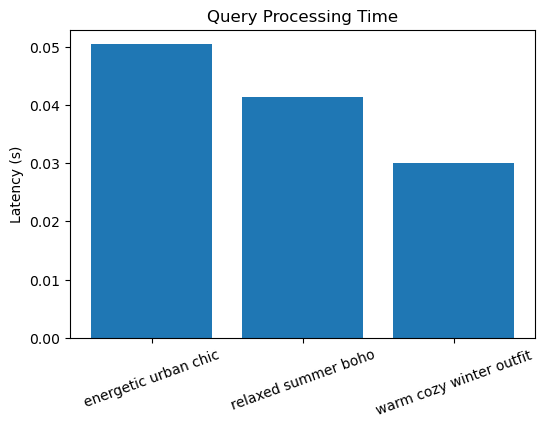

In [22]:
threshold = 0.7
eval_data = []

for q, val in results.items():
    if len(val["result"]):
        avg_sim = val["result"]["similarity"].mean()
        good = (avg_sim > threshold)
    else:
        avg_sim, good = 0, False
    
    eval_data.append({
        "query": q,
        "avg_similarity": avg_sim,
        "good_match": good,
        "latency": val["latency"]
    })

eval_df = pd.DataFrame(eval_data)
print(eval_df)

# Plot latency
plt.figure(figsize=(6,4))
plt.bar(eval_df["query"], eval_df["latency"])
plt.xticks(rotation=20)
plt.ylabel("Latency (s)")
plt.title("Query Processing Time")
plt.show()


In [23]:
reflection = [
    "Replaced paid OpenAI API with free SentenceTransformer model.",
    "Matches are quite strong for descriptive queries.",
    "Works fully offline — no key or quota limits.",
    "Can scale with FAISS or Pinecone later for large catalogs.",
    "Could enhance with images or user ratings for hybrid recommendations."
]

for point in reflection:
    print("-", point)


- Replaced paid OpenAI API with free SentenceTransformer model.
- Matches are quite strong for descriptive queries.
- Works fully offline — no key or quota limits.
- Can scale with FAISS or Pinecone later for large catalogs.
- Could enhance with images or user ratings for hybrid recommendations.
